# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
DATA_FOLDER = 'DATA' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

In [2]:
# Write your answer here  

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [ ]:
# Write your answer here

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [94]:
from IPython.core.display import HTML
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os  

df3 = pd.read_excel(DATA_FOLDER+'/titanic.xls')
HTML(filename=DATA_FOLDER+'/titanic.html')


Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [95]:
df3

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,S,10,NaN,"Hudson, NY"
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,S,NaN,NaN,"Belfast, NI"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,NaN,C,NaN,22.0,"Montevideo, Uruguay"


### 1. Describing the type of attributes

In [96]:
df3.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [97]:
df3.count()

pclass       1309
survived     1309
name         1309
sex          1309
age          1046
sibsp        1309
parch        1309
ticket       1309
fare         1308
cabin         295
embarked     1307
boat          486
body          121
home.dest     745
dtype: int64

From the information about the attributes of our dataset, we will set to caterogical (sex,cabin,embarked,boat and home.dest) features to categorical. Body, ticket and name normally being different for all passengers are not converted to categorical

In [98]:
print(np.shape(df3.groupby('name').count()))
df3.groupby('name').count()
a = df3.index[df3.name.isnull() == True]
df3.loc[a]
print((df3.name.value_counts()>1)[:5])

(1307, 13)
Kelly, Mr. James                                   True
Connolly, Miss. Kate                               True
Hart, Mrs. Benjamin (Esther Ada Bloomfield)       False
Moore, Mr. Clarence Bloomfield                    False
Smith, Mrs. Lucien Philip (Mary Eloise Hughes)    False
Name: name, dtype: bool


Here we can see that there are two people without names. when trying to see their attributes we see no rows. Maybe some people have their name written twice. Those people are Kelly, Mr. James and Connolly, Miss. Kate. Looking at their attributes, we will remove the versins with the least amount of data. loc[726,925]

In [99]:
df3[df3.name.isin(['Connolly, Miss. Kate','Kelly, Mr. James'])]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
725,3,1,"Connolly, Miss. Kate",female,22.0,0,0,370373,7.7500,NaN,Q,13,NaN,Ireland
726,3,0,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,NaN,NaN,Ireland
924,3,0,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,NaN,70.0,NaN
925,3,0,"Kelly, Mr. James",male,44.0,0,0,363592,8.0500,NaN,S,NaN,NaN,NaN


In [100]:
df3.drop(df3.index[[726,925]])

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,S,10,NaN,"Hudson, NY"
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,S,NaN,NaN,"Belfast, NI"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,NaN,C,NaN,22.0,"Montevideo, Uruguay"


In [101]:
#convert to categorical
df3["sex"] = pd.Categorical(df3['sex'], df3['sex'].unique())
df3['cabin'] = df3['cabin'].fillna('missing')
df3["cabin"] = pd.Categorical(df3['cabin'], df3['cabin'].unique())
df3['embarked'] = df3['embarked'].fillna('missing')
df3["embarked"] = pd.Categorical(df3['embarked'], df3['embarked'].unique())
df3['boat'] = df3['boat'].fillna('missing')
df3["boat"] = pd.Categorical(df3['boat'], df3['boat'].unique())
df3['home.dest'] = df3['home.dest'].fillna('missing')
df3["home.dest"] = pd.Categorical(df3['home.dest'], df3['home.dest'].unique())

df3.dtypes

pclass          int64
survived        int64
name           object
sex          category
age           float64
sibsp           int64
parch           int64
ticket         object
fare          float64
cabin        category
embarked     category
boat         category
body          float64
home.dest    category
dtype: object

In [102]:
# Write your answer here
df3.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


talk about range and type

In [103]:
df3.count()

pclass       1309
survived     1309
name         1309
sex          1309
age          1046
sibsp        1309
parch        1309
ticket       1309
fare         1308
cabin        1309
embarked     1309
boat         1309
body          121
home.dest    1309
dtype: int64

now all the missing values have been cleaned except for the body column. Since there are only 121 entries out of 1309, we will see later if we remove this column.

### 2. Plot histograms

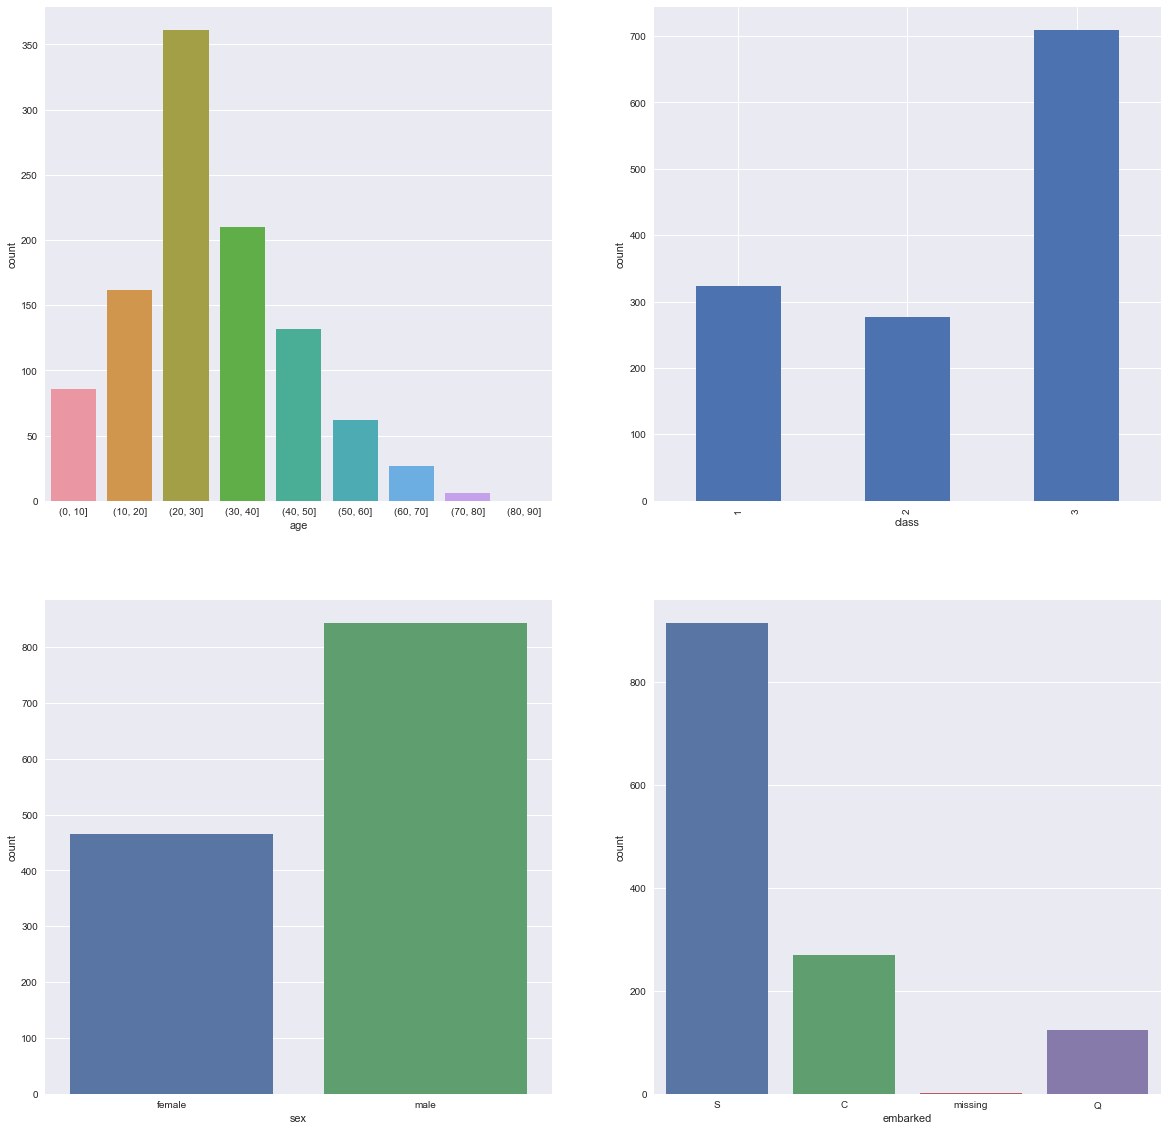

In [104]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(20,20)

df_temporary = df3.copy()
df_temporary.age = pd.cut(df3.age, [0,10,20,30,40,50,60,70,80,90])
sns.countplot(x='age',data=df_temporary,ax=axes[0,0])
axes[0,0].set_xlabel('age')
axes[0,0].set_ylabel('count')

classes = df3.groupby('pclass').size()
#df3.hist('pclass',ax=axes[0,1])
classes.plot(kind='bar',ax=axes[0,1])
axes[0,1].set_xlabel('class')
axes[0,1].set_ylabel('count')

sns.countplot(x='sex',data=df3,ax=axes[1,0])

sns.countplot(x='embarked',data=df3)

### Histogram observations
- We can observe the passenger age distribution in the titanic is gaussian
- There is a higher amount of males onboard
- There were more people embarked in third class then first and second combined
- Most of the passengers boarded in Southampton

### 3. Calculate the proportion of passengers by cabin floor
We make the assumption that for cabins with name as 'F E69' belong to the cabin floor F

In [105]:
df3['cabin_floor'] = df3.cabin.apply(lambda x: x[0])
df3.cabin_floor = df3.cabin_floor[df3.cabin_floor != 'm']

In [106]:
#plt.pie(df3.groupby('cabin_floor').count())
import plotly as ip
#plt.pie(df3.groupby('cabin_floor').count())
import plotly.plotly as py
import plotly.graph_objs as go
ip.tools.set_credentials_file(username='mgelsm', api_key='Qz6Uo0EULsJVa5MMU3uc')
trace = go.Pie(labels=df3['cabin_floor'].value_counts().index, values=df3['cabin_floor'].value_counts())

py.iplot([trace], filename='Proportion of passengers per cabin floor')


### 4. For each travel class, calculate the proportion of the passengers that survived. Present your results in pie charts.

In [107]:
fig = ip.tools.make_subplots(rows=3, cols=1)
trace1 = go.Pie(labels=df3.loc[df3.pclass == 1].survived.value_counts().index, values=df3.loc[df3.pclass == 1].survived.value_counts())
fig.append_trace(trace1, 1, 1)
trace2 = go.Pie(labels=df3.loc[df3.pclass == 2].survived.value_counts().index, values=df3.loc[df3.pclass == 2].survived.value_counts())
fig.append_trace(trace2, 2, 1)
trace1 = go.Pie(labels=df3.loc[df3.pclass == 3].survived.value_counts().index, values=df3.loc[df3.pclass == 1].survived.value_counts())
fig.append_trace(trace3, 3, 1)
py.plot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



PlotlyDictKeyError: 'xaxis' is not allowed in 'pie'

Path To Error: ['xaxis']

Valid attributes for 'pie' at path [] under parents []:

    ['customdata', 'customdatasrc', 'direction', 'dlabel', 'domain',
    'hole', 'hoverinfo', 'hoverinfosrc', 'hoverlabel', 'hovertext',
    'hovertextsrc', 'ids', 'idssrc', 'insidetextfont', 'label0', 'labels',
    'labelssrc', 'legendgroup', 'marker', 'name', 'opacity',
    'outsidetextfont', 'pull', 'pullsrc', 'rotation', 'scalegroup',
    'showlegend', 'sort', 'stream', 'text', 'textfont', 'textinfo',
    'textposition', 'textpositionsrc', 'textsrc', 'type', 'uid', 'values',
    'valuessrc', 'visible']

Run `<pie-object>.help('attribute')` on any of the above.
'<pie-object>' is the object at []

### 5. Calculate the proportion of the passengers that survived by travel class and sex. Present your results in a single histogram

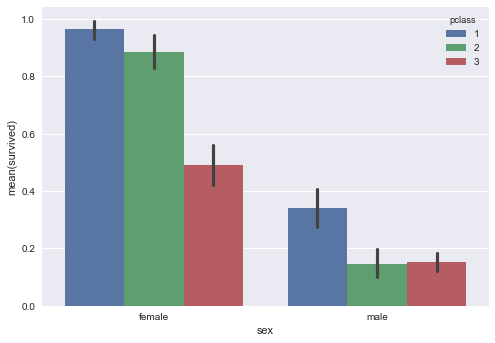

In [108]:
import seaborn as sns
sns.barplot(x='sex',y='survived',hue='pclass',data=df3)

Here we can see that more women survived from the titanic sinking and upper classes have a higher rate of survival.

### 6. Create 2 equally populated age categories and calculate survival proportions by age category, travel class and sex. Present your results in a DataFrame with unique index.

In [114]:
df3['age_class'] = df3.age < df3.age.median()
df3.age.median()

28.0

In [115]:
def create_category(x):
    if x.age_class == False and x.sex == 'female':
        val = 'young_female'
    elif x.age_class == True and x.sex == 'female':
        val = 'old_female'
    elif x.age_class == False and x.sex == 'male':
        val = 'young_male'
    else:
        val = 'old_male'   
    return val
            
    

In [116]:
df3.survived.groupby([df3.age_class,df3.sex]).apply(create_category)

AttributeError: 'Series' object has no attribute 'age_class'

In [112]:
df3['age_sex'] = df3.apply(create_category,axis=1)

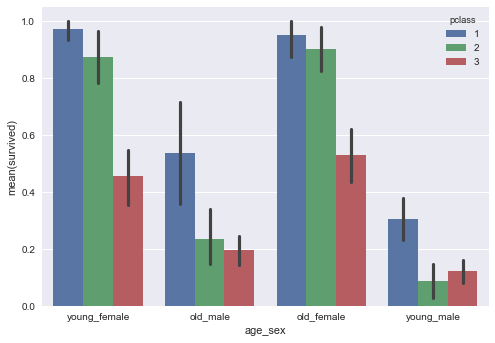

In [113]:
sns.barplot(x='age_sex',y='survived',hue='pclass',data=df3)